# Onboarding Process Analysis

## Background

Company X has conducted an experiment on its applicants in an effort to increase the success rate of their onboarding process. We are interested in whether or not the experimental process is better than the old process. Below is the data dictionary for the provided dataset.

Data dict:
 - shopper_ID: unique ID for the applicant
 - county: county of applicant
 - group: group of applicant (C: control, T: treatment)
 - event: milestone that the applicant hit in onboarding process
 - event date: date that the applicant hit milestone
 
Idea: To determine whether there are differences in the results of our onboarding process between the control group and treatment group, we can perform a chi-squared test on 'group' and 'event', where:
 - Null Hypothesis: There is no association between 'group' and 'event'.
 - Alternative Hypothesis: There is an association between 'group' and 'event'.

Before we jump into performing the test, there are things we need to consider:
 - whether or not we are interested in the specific events other than 'first delivery complete'
 - whether or not the county of the applicant has a relationship with the onboarding process

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv('onboarding.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35094 entries, 0 to 35093
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   shopper_ID  35094 non-null  int64 
 1   county      35094 non-null  object
 2   group       35094 non-null  object
 3   event       35094 non-null  object
 4   event date  35094 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


Our dataset has 35094 rows and 5 columns with no null values.

In [4]:
data.head()

,shopper_ID,county,group,event,event date
0,82074760,San Francisco,T,background check,9/6/19
1,31670374,Contra Costa,T,background check,8/31/19
2,31368449,Contra Costa,T,first delivery complete,11/8/19
3,57381213,Alameda,C,orientation,10/15/19
4,14801885,Santa Clara,C,card issued,9/16/19


## Data Cleaning

In [5]:
data[data['group'] == 'T']['event'].value_counts()

application                4416
background check           3716
card issued                3007
orientation                2320
first delivery complete    1622
Name: event, dtype: int64

In [6]:
data[data['group'] == 'C']['event'].value_counts()

application                5705
background check           4853
card issued                3984
orientation                3141
first delivery complete    2330
Name: event, dtype: int64

If we take a look at the frequency distributions of the events, we can see that the frequency of each event decreases further down the process. This is not surprising in our dataset because every milestone of each applicant was recorded. We will need to trim our data to only show the furthest point each applicant reached in order to perform a chi-squared test, because it is built on the assumption that the categorical variable, in this case 'event', is mutually exclusive.

We will convert each event to their respective numerical value in the onboarding process, then remove all values lower than the highest value for each shopper_ID.

In [7]:
def event_to_step(event: str) -> int:
    if event == 'application':
        return 1
    elif event == 'background check':
        return 2
    elif event == 'card issued':
        return 3
    elif event == 'orientation':
        return 4
    else:
        return 5

data['step'] = data['event'].apply(event_to_step)
data = data.sort_values('step', ascending = False)
#drop by group as well to act as a proxy to check for shopper_IDs that are in both groups
cleaned_data = data.copy().drop_duplicates(subset = ['shopper_ID', 'group'])

In [8]:
cleaned_data['shopper_ID'].value_counts()

45021483    2
70982993    1
47457614    1
76758349    1
13931848    1
           ..
42669693    1
20492963    1
83196578    1
75147936    1
25575424    1
Name: shopper_ID, Length: 10120, dtype: int64

Since shopper_ID should be unique to the applicant and an applicant should only be a part of a single group, we should not have duplicate shopper_IDs in our cleaned dataset. However, there seems to be an issue with shopper_ID "45021483". We will need to investigate further.

In [9]:
data[data['shopper_ID'] == 45021483]

,shopper_ID,county,group,event,event date,step
33563,45021483,San Francisco,T,card issued,10/18/19,3
4371,45021483,San Francisco,C,card issued,10/7/19,3
2995,45021483,San Francisco,C,background check,9/19/19,2
11476,45021483,San Francisco,T,background check,9/27/19,2
2459,45021483,San Francisco,C,application,9/7/19,1
18200,45021483,San Francisco,T,application,9/10/19,1


shopper_ID "45021483" appears in the treatment and control group, but based on the information, it seems likely that this shopper_ID refers to two different people since the onboarding process is concurring around the same time for the respective groups.

Given that there was likely a typo in this scenario, it is important to check for other errors in our data. The number of times a shopper_ID occurs in our dataset should be equal to the furthest step that shopper reached.

In [10]:
shopper_incorrect = []
for shopper in data['shopper_ID'].unique():
    shopper_steps = data[data['shopper_ID'] == shopper]['step']
    if max(shopper_steps) != len(shopper_steps):
        shopper_incorrect.append(shopper)

shopper_incorrect

[45021483]

It seems like shopper_ID "45021483" is the only shopper_ID that has an issue. Even though we can assume that the error was likely a typo and count the shopper in its respective group, it may be best to remove shopper_ID "45021483" from the dataset since it has minimal data loss.

In [11]:
cleaned_data.drop(cleaned_data[cleaned_data['shopper_ID'] == 45021483].index, inplace = True)

### Do we care if an applicant completes other parts of the onboarding process?

In order to answer this question, we need to consider what the chi-squared test is testing and what our primary goal is. If we were to perform a chi-squared test with all events, we will be testing whether or not there are differences in the distribution of the frequencies of any of the events between the control and the treatment group. However, our primary goal is to determine if the experimental process results in an increase in the number of successful applicants. Therefore, we are only interested in whether the applicant was successfully onboarded or not, allowing us to clump all other events into the same group.

In [12]:
def onboarded(num: int) -> str:
    if num == 5:
        return 'Onboarded'
    else:
        return 'Not Onboarded'

cleaned_data['onboarded'] = cleaned_data['step'].apply(onboarded)

### Does the county have relationship with the onboarding process?

This is another important question that needs to be considered. Without any analysis or additional information, it is possible that Company X offers different rates based on county or a county having specific regulations that can affect Company X's onboarding process. In order to determine if there was evidence of a such a relationship, we can perform a chi-squared test between the applicant's county and whether or not the applicant was onboarded.

In [13]:
county_onboarded_pvalue = chi2_contingency(pd.crosstab(cleaned_data['county'], cleaned_data['onboarded']))[1]
print('p_value: ' + str(county_onboarded_pvalue))

p_value: 0.0


The results of the chi-squared test indicate that there evidence of a relationship between 'county' and 'onboarded'. Let's take a look at some visualizations in order to get a better understanding of this relationship.

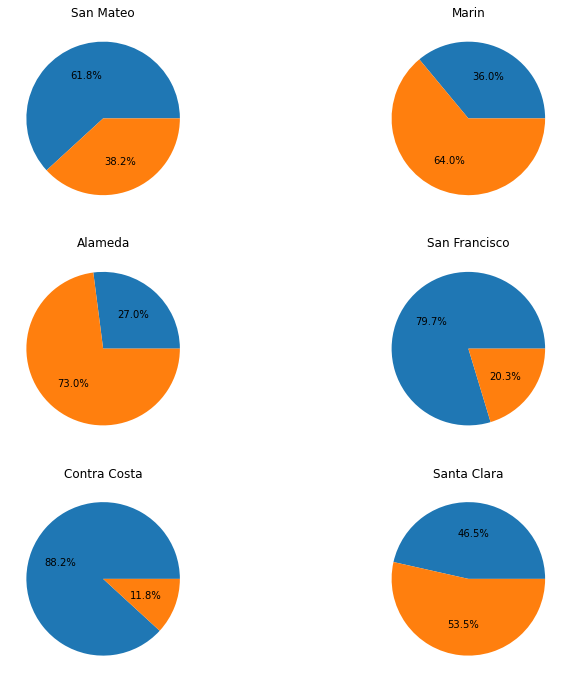

In [14]:
figure, axs = plt.subplots(3, 2, figsize = (12, 12))
row = 0
col = 0
for county in cleaned_data['county'].unique():
    county_data = cleaned_data[cleaned_data['county'] == county]
    axs[row, col].pie(county_data['onboarded'].value_counts().sort_index(), autopct='%1.1f%%')
    axs[row, col].set_title(county)
    if row == 2:
        row = 0
        col += 1
    else:
        row += 1
plt.show()

Based on the pie charts, we can see that the percentage of onboarded vs. not onboarded varies dramatically across the different counties, which supports the results of the chi-squared test.

### Chi-Square Test of 'Group' vs. 'Onboarded' 

We now have the necessary information to perform our final test. For each county, we will now perform a chi-squared test between 'group' and 'onboarded' with the updated null and alternative hypothesis:
 - Null Hypothesis: There is no difference in the distribution of applicants onboarded and the two onboarding processes.
 - Alternative Hypothesis: There is a difference in the distribution of applicants onboarded and the two onboarding processes.

In [15]:
group_onboarded_pvalues = dict()
for county in cleaned_data['county'].unique():
    county_data = cleaned_data[cleaned_data['county'] == county]
    results = chi2_contingency(pd.crosstab(county_data['group'], county_data['onboarded']))
    group_onboarded_pvalues[county] = results[1]
    print(county + ':')
    print(results)
    print('\n')

San Mateo:
(1.6184701673182862, 0.2033052329049269, 1, array([[213.25356415, 131.74643585],
       [393.74643585, 243.25356415]]))


Alameda:
(2.3586005854564402, 0.12459391390624446, 1, array([[287.23590055, 774.76409945],
       [158.76409945, 428.23590055]]))


Contra Costa:
(9.654579600457948, 0.0018888011396266506, 1, array([[1402.99823633,  188.00176367],
       [1097.00176367,  146.99823633]]))


Marin:
(1.1969032635806915, 0.2739414957339342, 1, array([[390.58789205, 693.41210795],
       [103.41210795, 183.58789205]]))


San Francisco:
(3.87619685713681, 0.04897537912276488, 1, array([[564.10720268, 143.89279732],
       [862.89279732, 220.10720268]]))


Santa Clara:
(2.4502490267324353, 0.117506224736855, 1, array([[424.81690141, 489.18309859],
       [268.18309859, 308.81690141]]))




Based on the results of the chi-squared tests, at the 5% significance level, we reject the null hypothesis for Contra Costa and San Francisco and fail to reject the null hypothesis for the other counties.

Note that the results of a chi-squared test only provide evidence if a relationship exists between the variables, but it does not determine a direction for the relationship (i.e. we do not know if the percent of successfully onboarded increases or decreases with the experimental process compared to the old process). In order to identify the direction, let's visit some visualizations.

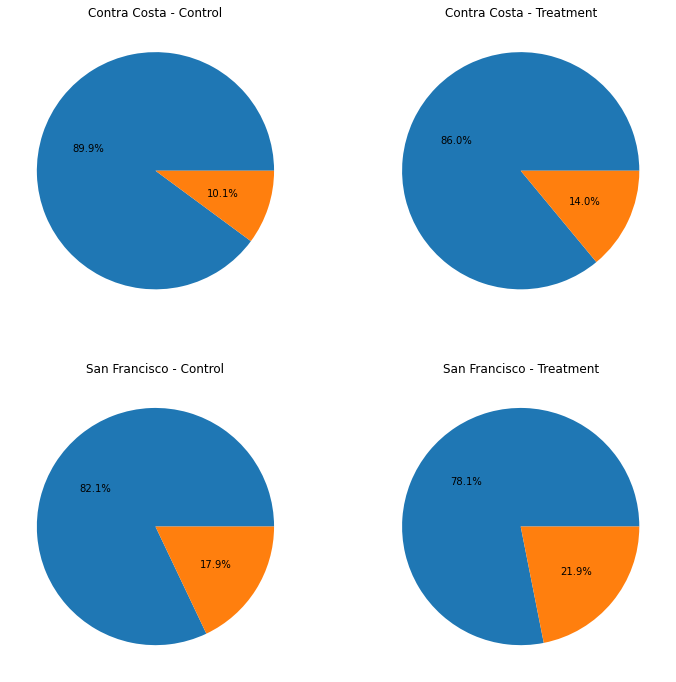

In [16]:
cc_data = cleaned_data[cleaned_data['county'] == 'Contra Costa']
sf_data = cleaned_data[cleaned_data['county'] == 'San Francisco']

figure, axs = plt.subplots(2, 2, figsize = (12, 12))
axs[0, 0].pie(cc_data[cc_data['group'] == 'C']['onboarded'].value_counts().sort_index(), autopct='%1.1f%%')
axs[0, 0].set_title('Contra Costa - Control')
axs[0, 1].pie(cc_data[cc_data['group'] == 'T']['onboarded'].value_counts().sort_index(), autopct='%1.1f%%')
axs[0, 1].set_title('Contra Costa - Treatment')
axs[1, 0].pie(sf_data[sf_data['group'] == 'C']['onboarded'].value_counts().sort_index(), autopct='%1.1f%%')
axs[1, 0].set_title('San Francisco - Control')
axs[1, 1].pie(sf_data[sf_data['group'] == 'T']['onboarded'].value_counts().sort_index(), autopct='%1.1f%%')
axs[1, 1].set_title('San Francisco - Treatment')
plt.show()

The visualizations show us that the percentage of successfully onboarded applicants is higher for applicants in the treatment group compared to control group.

## Conclusion

Based on our analysis, we recommend that the experimental onboarding process is used in place of the old one in San Francisco county and Contra Costa county. As for the remaining counties, there does not appear to be a significant difference between the two processes. For the reasons of cost and consistency, it may be worthwhile to also use the experimental process in these counties.